In [25]:
from encoder import QTModel
import torch
import numpy as np
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torch.autograd import Variable
from nltk.tokenize import sent_tokenize as ST
import nltk

In [26]:
W2V_PATH = "/home/jingjing/Desktop/InferSent-master/dataset/GloVe/glove.840B.300d.txt"

In [27]:
#f = open('/home/jingjing/Desktop/small.txt', 'r')
with open('/home/jingjing/Desktop/big.txt', 'r') as in_file:
    text = in_file.read()
    sents = nltk.sent_tokenize(text)

In [28]:
#paragraphs = splat
data = sents
len(data)

348069

In [29]:
sentences = ['Doctors lead a hard life.',
             'Their life is very busy.',
             'They get up early in the morning and go to the hospital.']
#data = []
#for p in paragraphs:
#    nl = ST(p)
#    if len(nl) > 1:
#        data.append(ST(p))

In [30]:
f = QTModel()
f.set_w2v_path(W2V_PATH)

In [31]:
def make_target(context_size, dim):
    targets = np.zeros((dim, dim))
    ctxt_sent_pos = list(range(-context_size, context_size+1))
    ctxt_sent_pos.remove(0)
    for ctxt in ctxt_sent_pos:
        targets += np.eye(dim, k=ctxt)
    targets_sum = np.sum(targets,axis=1, keepdims=True)
    targets = targets / targets_sum
    targets = torch.from_numpy(targets)
    return targets

In [32]:
def loss_fn(pred, target):
    mask = 1 - torch.diag(torch.ones(pred.size(1)))
    npred = pred * mask
    s_pred = F.softmax(npred, -1)
    ln = nn.BCELoss(
        size_average=False
    )
    losses = ln(s_pred, target)
    return losses

In [36]:
with torch.no_grad():
    f.build_vocab(sentences, True)
    embs = f(sentences, 400, True, True)
    print(embs)
    targets = make_target(1, len(sentences))
    loss = loss_fn(embs, targets.float())
    print("loss before training: ", loss)

Found 23(/23) words with w2v vectors
Vocab size : 23
Found 23(/23) words with w2v vectors
Vocab size : 23
Nb words kept : 31/31 (100.0%)
Speed : 81.7 sentences/s (cpu mode, bsize=400)
Nb words kept : 31/31 (100.0%)
Speed : 83.0 sentences/s (cpu mode, bsize=400)
tensor([[ 13.8343,  13.0828,  12.9733],
        [ 13.0828,  14.3033,  13.3851],
        [ 12.9733,  13.3851,  14.0952]])
loss before training:  tensor(3.7054)


In [34]:
optimizer = optim.Adam(f.parameters(), lr=0.0005)
nn.utils.clip_grad_norm_(f.parameters(), 5)

0.0

In [42]:
print(len(data))
data = data[:3]

30


In [43]:
for epoch in range(10):
    optimizer.zero_grad()
    #if epoch == 0:
    #    f.build_vocab(data, True)
    targets = make_target(1, len(data))
    scores = f(data, 400)
    loss = loss_fn(scores, targets.float())
    print(loss)
    loss.backward()
    optimizer.step()

tensor(1.6348)
tensor(1.5354)
tensor(1.4775)
tensor(1.5697)
tensor(1.5414)
tensor(1.4421)
tensor(1.4819)
tensor(1.5023)
tensor(1.4211)
tensor(1.4313)


In [15]:
scores

tensor([[ 13.7052,  12.2488,  12.3763,  ...,  12.3315,  12.7218,
          12.2630],
        [ 12.2488,  13.5968,  12.5174,  ...,  12.5708,  12.6317,
          12.2759],
        [ 12.3763,  12.5174,  14.7313,  ...,  14.2081,  13.0468,
          13.0308],
        ...,
        [ 12.3315,  12.5708,  14.2081,  ...,  15.0949,  13.1594,
          12.8347],
        [ 12.7218,  12.6317,  13.0468,  ...,  13.1594,  14.0605,
          12.7751],
        [ 12.2630,  12.2759,  13.0308,  ...,  12.8347,  12.7751,
          13.5692]])

In [44]:
with torch.no_grad():
    #f.build_vocab(sentences, True)
    embeddings = f(sentences, 400)
    targets = make_target(1, len(sentences))
    loss = loss_fn(embeddings, targets.float())
    print("loss after training: ", loss)

loss after training:  tensor(6.4941)


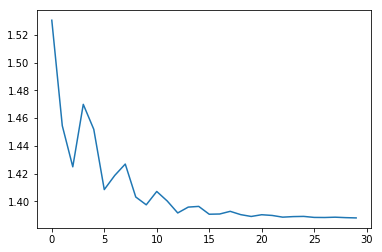

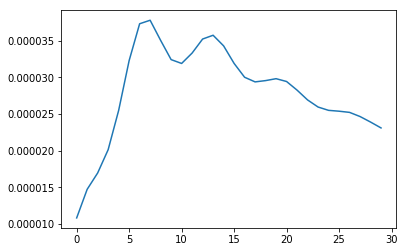

In [41]:
import matplotlib.pyplot as plt

for i in range(len(trdata)):
    plt.figure(i)
    plt.plot(trdata[i][1:])
    plt.show()
